### `import` Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import ee
import geemap
import requests

import numpy as np
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin

from ipyleaflet import (Choropleth, Marker, Popup, WidgetControl)
from ipywidgets import (HTML, Text)

from matplotlib import pyplot as plt
from matplotlib import style

style.use('seaborn-deep')

In [2]:
ee.Initialize()

**ORS Token**

In [3]:
with open(file='ors_token.txt', mode='r') as ors:
    api_key = ors.read()

**Geocoder**

In [4]:
def geocode(place, api_key):
    url = 'https://api.openrouteservice.org/geocode/search?api_key={}&text={}'
    url = url.format(api_key, place)
    
    headers = {
        'Accept' : 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
    }

    req = requests.get(url=url, headers=headers)
    print('Geocode response status - {} : {} {}'.format(place, req.status_code, req.reason))

    if (req.status_code == 200):
        req_data = req.json()
        features = req_data['features']
        # format - [longitude, latitude]
        coords = features[0]['geometry']['coordinates']
        return coords

    return None

### Data Reading

* Source → https://www.kaggle.com/slwessels/crime-statistics-for-south-africa

In [5]:
popn_province_df = pd.read_csv(filepath_or_buffer='Crimes_SA/ProvincePopulation.csv')
sa_crimes_df = pd.read_csv(filepath_or_buffer='Crimes_SA/SouthAfricaCrimeStats_v2.csv')
police_bounds_gdf = gpd.read_file(filename='Crimes_SA/Police_points.shp')

In [6]:
sa_crimes_df.head()

,Province,Station,Category,2005-2006,2006-2007,2007-2008,2008-2009,2009-2010,2010-2011,2011-2012,2012-2013,2013-2014,2014-2015,2015-2016
0,Western Cape,Cape Town Central,All theft not mentioned elsewhere,6692,6341,5966,5187,4985,5127,5285,5937,5600,5335,5176
1,Gauteng,Jhb Central,All theft not mentioned elsewhere,6093,4602,3761,3610,3267,3037,2886,2638,2809,3050,2434
2,Western Cape,Mitchells Plain,All theft not mentioned elsewhere,5341,6093,6316,6803,6035,5761,6108,5514,4975,4043,3635
3,Free State,Park Road,All theft not mentioned elsewhere,5108,4282,3834,3316,3101,3013,2679,3116,2927,2297,2103
4,Gauteng,Pretoria Central,All theft not mentioned elsewhere,5099,4536,3309,2694,2616,2606,2635,3226,3246,2892,3030


In [7]:
police_bounds_gdf['COMPNT_NM'] = police_bounds_gdf['COMPNT_NM'].apply(lambda x: x.title())
police_bounds_gdf['CREATE_YEAR'] = police_bounds_gdf['CREATE_DT'].apply(lambda x: str(x)[:4])

In [8]:
print('Population Province - shape : ', popn_province_df.shape)
print('SA Crimes Data - shape : ', sa_crimes_df.shape)
print('Police Bounds Data - shape : ', police_bounds_gdf.shape)

Population Province - shape :  (9, 4)
SA Crimes Data - shape :  (30861, 14)
Police Bounds Data - shape :  (1143, 7)


### Additional Data

**SA - Country, States, Districts**

* Download data by country → https://www.diva-gis.org/gdata

In [9]:
sa_country = gpd.read_file(filename='south_africa/south_africa.shp')
sa_states = gpd.read_file(filename='ZAF_adm1/ZAF_adm1.shp')
sa_districts = gpd.read_file(filename='ZAF_adm2/ZAF_adm2.shp')

In [10]:
sa_districts.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,geometry
0,211,ZAF,South Africa,1,Eastern Cape,1,Aberdeen,Magisterial District,Magisterial District,None,None,"POLYGON ((23.98008 -33.06299, 23.61392 -32.932..."
1,211,ZAF,South Africa,1,Eastern Cape,2,Adelaide,Magisterial District,Magisterial District,None,None,"POLYGON ((26.44046 -32.37127, 26.42860 -32.961..."
2,211,ZAF,South Africa,1,Eastern Cape,3,Albany,Magisterial District,Magisterial District,None,None,"POLYGON ((25.99546 -33.31073, 25.99545 -33.101..."
3,211,ZAF,South Africa,1,Eastern Cape,4,Albert,Magisterial District,Magisterial District,None,None,"POLYGON ((26.70680 -31.15412, 26.68253 -31.186..."
4,211,ZAF,South Africa,1,Eastern Cape,5,Alexandria,Magisterial District,Magisterial District,None,None,"POLYGON ((25.86850 -33.71847, 25.84171 -33.681..."


In [11]:
sa_districts.drop(columns=['NL_NAME_2', 'VARNAME_2'], inplace=True)
sa_districts.dropna(axis=0, inplace=True)
sa_districts['NAME_1'] = sa_districts['NAME_1'].apply(lambda x: x.title().replace('-', '/'))

In [12]:
sa_districts.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,TYPE_2,ENGTYPE_2,geometry
0,211,ZAF,South Africa,1,Eastern Cape,1,Aberdeen,Magisterial District,Magisterial District,"POLYGON ((23.98008 -33.06299, 23.61392 -32.932..."
1,211,ZAF,South Africa,1,Eastern Cape,2,Adelaide,Magisterial District,Magisterial District,"POLYGON ((26.44046 -32.37127, 26.42860 -32.961..."
2,211,ZAF,South Africa,1,Eastern Cape,3,Albany,Magisterial District,Magisterial District,"POLYGON ((25.99546 -33.31073, 25.99545 -33.101..."
3,211,ZAF,South Africa,1,Eastern Cape,4,Albert,Magisterial District,Magisterial District,"POLYGON ((26.70680 -31.15412, 26.68253 -31.186..."
4,211,ZAF,South Africa,1,Eastern Cape,5,Alexandria,Magisterial District,Magisterial District,"POLYGON ((25.86850 -33.71847, 25.84171 -33.681..."


**Converting `.shp` files into `ee` objects**

In [13]:
sa_country_ee = geemap.geopandas_to_ee(gdf=sa_country)
sa_states_ee = geemap.geopandas_to_ee(gdf=sa_states)
# sa_districts_ee = geemap.geopandas_to_ee(gdf=sa_districts)

In [14]:
location = geocode(place='south africa', api_key=api_key)
location = location[::-1]

Geocode response status - south africa : 200 OK


**South Africa - Provinces**

In [15]:
# m = geemap.Map(location=location, zoom=5)

# m.addLayer(ee_object=sa_country_ee, vis_params={}, name='SA Country', shown=False)
# m.addLayer(ee_object=sa_states_ee, vis_params={}, name='SA States')
# # m.addLayer(ee_object=sa_districts_ee, vis_params={}, name='SA Districts', shown=False)

# m

**Merging `sa_states` and `popn_province_df`**

In [16]:
sa_states = sa_states[['NAME_1', 'geometry']]
sa_states.columns = ['Province', 'geometry']
sa_states['Province'] = sa_states['Province'].apply(lambda x: x.title().replace('-', '/'))
sa_provinces_df  = popn_province_df.merge(right=sa_states, on='Province', how='right')
sa_provinces_gdf = gpd.GeoDataFrame(sa_provinces_df)
sa_provinces_gdf = sa_provinces_gdf.set_index(keys='Province')
sa_provinces_gdf.head()

,Population,Area,Density,geometry
Province,,,,
Eastern Cape,6562053,168966,38.8,"POLYGON ((30.19697 -31.07903, 29.99014 -31.312..."
Free State,2745590,129825,21.1,"POLYGON ((28.28889 -26.91306, 28.48056 -26.959..."
Gauteng,12272263,18178,675.1,"POLYGON ((28.28889 -26.91306, 28.07222 -26.838..."
Kwazulu/Natal,10267300,94361,108.8,"POLYGON ((30.19697 -31.07903, 30.05333 -30.846..."
Limpopo,5404868,125755,43.0,"POLYGON ((31.87546 -23.95414, 31.77695 -23.965..."


In [17]:
sa_provinces_gdf.index.to_list()

['Eastern Cape',
 'Free State',
 'Gauteng',
 'Kwazulu/Natal',
 'Limpopo',
 'Mpumalanga',
 'North West',
 'Northern Cape',
 'Western Cape']

### EDA and Visualization

**Population of each province of SA**

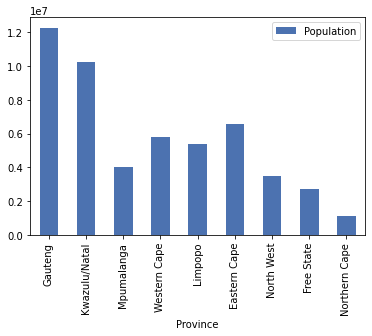

In [18]:
popn_province_df.plot(x='Province', y='Population', kind='bar')
plt.show()

**Choropleth map visualization of provinces w.r.t population**

In [19]:
m = geemap.Map(location=location, zoom=5)

choropleth_layer = Choropleth(
    geo_data=sa_provinces_gdf.geometry.__geo_interface__,
    choro_data=dict(sa_provinces_gdf['Population']),
    style={'fillOpacity': 1.0, "color":"black"}
)

m.add_layer(layer=choropleth_layer)

m

Map(center=[-31.3096, 18.357], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chi…

**All Crimes**

In [20]:
crimes_list = sa_crimes_df['Category'].value_counts().index.to_list()
crimes_list

['Theft of motor vehicle and motorcycle',
 'Truck hijacking',
 'Sexual offences as result of police action',
 'All theft not mentioned elsewhere',
 'Commercial crime',
 'Burglary at residential premises',
 'Driving under the influence of alcohol or drugs',
 'Common robbery',
 'Robbery at residential premises',
 'Drug-related crime',
 'Common assault',
 'Robbery with aggravating circumstances',
 'Attempted murder',
 'Sexual Offences',
 'Illegal possession of firearms and ammunition',
 'Malicious damage to property',
 'Robbery at non-residential premises',
 'Bank robbery',
 'Carjacking',
 'Murder',
 'Shoplifting',
 'Arson',
 'Burglary at non-residential premises',
 'Assault with the intent to inflict grievous bodily harm',
 'Theft out of or from motor vehicle',
 'Stock-theft',
 'Robbery of cash in transit']

**Crimes (single) reported per station in a selected province and year**

In [21]:
def get_coords(police_df, station):
    try:
        coords = police_df[police_df['COMPNT_NM'] == station].geometry.values[0]
    except Exception as e:
        coords = None
    return coords

def fetch_crime_by_stations(province, crimes_data, police_data, category, year, threshold=20, showplot=False):
    if not province:
        return None
    
    if not year in range(2005, 2016):
        return None
    
    start_year = year
    end_year = start_year + 1
    year_col = '{}-{}'.format(start_year, end_year)
    
    p_df = crimes_data[crimes_data['Province'] == province]
    pc_df = p_df[p_df['Category'] == category]
    sc_df = pc_df[['Station', year_col]]
    
    sc_df = pc_df.groupby(by='Station').sum()
    sc_df = sc_df.reset_index()
    
    if isinstance(threshold, int):
        sc_df = sc_df[sc_df[year_col] > threshold]
    
    sc_df['geometry'] = [get_coords(police_df=police_data, station=i) for i in sc_df['Station']]
    
    if showplot:
        fig, ax = plt.subplots()
        plt.title('Crime Category : {}; Province : {}'.format(category, province))
        sc_df.plot(x='Station', y=year_col, kind='barh', figsize=(10, 10), ax=ax)
        plt.show()
        return None
    
    return gpd.GeoDataFrame(sc_df)

**Murders in the year `2006`**

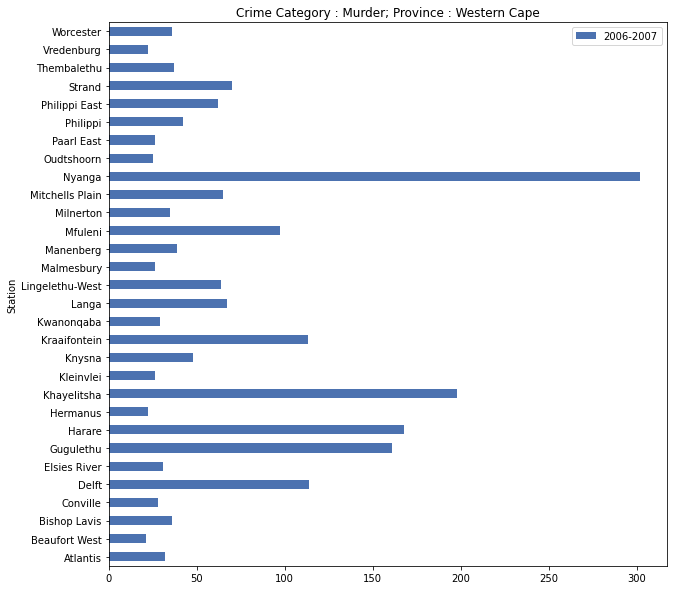

In [22]:
fetch_crime_by_stations(
    province='Western Cape',
    crimes_data=sa_crimes_df,
    police_data=police_bounds_gdf,
    category='Murder',
    year=2006,
    showplot=True
)

**Murders in the year `2010`**

In [23]:
# fetch_crime_by_stations(
#     province='Eastern Cape',
#     crimes_data=sa_crimes_df,
#     police_data=police_bounds_gdf,
#     category='Murder',
#     year=2010,
#     showplot=True
# )

**Plot stations by province**

In [24]:
def plot_stations_by_province(province, district_bounds, crimes_data, police_data, category, year):
    start_year = year
    end_year = start_year + 1
    year_col = '{}-{}'.format(start_year, end_year)
    
    sc_gdf = fetch_crime_by_stations(
        province=province,
        crimes_data=crimes_data,
        police_data=police_data,
        category=category,
        year=year
    )
    
    province_districts = district_bounds[district_bounds['NAME_1'] == province]
    province_districts_ee = geemap.geopandas_to_ee(gdf=province_districts)
    province_location = geocode(place=province, api_key=api_key)
    province_location = province_location[::-1]
    
    m = geemap.Map(location=province_location, zoom=7)
    m.addLayer(ee_object=province_districts_ee, vis_params={}, name=province)
    
    for (each_point, each_station, each_count) in zip(sc_gdf['geometry'], sc_gdf['Station'], sc_gdf[year_col]):
        each_loc = [each_point.y, each_point.x]
        each_marker = Marker(
            location=each_loc,
            draggable=False,
            # title='{}; {}'.format(each_station, each_count)
        )
        each_message = HTML()
        each_message.value = '{}; {}'.format(each_station, each_count)
        m.add_layer(each_marker)
        each_marker.popup = each_message
    
    return m

In [25]:
plot_stations_by_province(
    province='Western Cape',
    district_bounds=sa_districts,
    crimes_data=sa_crimes_df,
    police_data=police_bounds_gdf,
    category='Murder',
    year=2006
)

Geocode response status - Western Cape : 200 OK


Map(center=[-33.582933, 19.760643], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBo…

**Plot choropleth map with the count of stations (where crimes have occurred) per district**

* Spatial join operation to check if a station (point) exists in district (polygon).

In [26]:
def plot_choropleth_by_year(province, district_bounds, crimes_data, police_data, category, year):
    start_year = year
    end_year = start_year + 1
    year_col = '{}-{}'.format(start_year, end_year)
    
    sc_gdf = fetch_crime_by_stations(
        province=province,
        crimes_data=crimes_data,
        police_data=police_data,
        category=category,
        year=year
    )
    
    province_districts = district_bounds[district_bounds['NAME_1'] == province]
    province_districts_ee = geemap.geopandas_to_ee(gdf=province_districts)
    province_location = geocode(place=province, api_key=api_key)
    province_location = province_location[::-1]
    
    sinprovince = sjoin(left_df=sc_gdf, right_df=province_districts, how="right")
    sinprovince = sinprovince.dropna(axis=0)
    sinprovince = sinprovince[['Station', 'NAME_2', year_col]]
    sinprovince = sinprovince.groupby(by='NAME_2').sum()
    sinprovince['geometry'] = [
        province_districts[province_districts['NAME_2'] == i]['geometry'].values[0] for i in sinprovince.index
    ]
    sinprovince = gpd.GeoDataFrame(sinprovince)
    
    m = geemap.Map(location=province_location, zoom=7)
    m.addLayer(ee_object=province_districts_ee, vis_params={}, name='{} Districts'.format(province))

    choropleth_layer = Choropleth(
        geo_data=sinprovince.geometry.__geo_interface__,
        choro_data=dict(sinprovince[year_col]),
        style={'fillOpacity': 1.0, "color":"black"}
    )

    m.add_layer(layer=choropleth_layer)
    
    html = HTML('''
        <h4>Province : <b>{}</b></h4>
        Hover over a district
    '''.format(province))
    html.layout.margin = '0px 20px 20px 20px'
    control = WidgetControl(widget=html, position='bottomright')
    
    m.add_control(control)
    def update_html(feature, **kwargs):
        # print(feature)
        html.value = '''
            <h4>Province : <b>{}</b></h4>
            <p>District : <b>{}</b></p>
            <p>Year : <b>{}</b></p>
            <p>Crime category : <b>{}</b></p>
            <p>Cases reported : <b>{}</b></p>
        '''.format(
                province, 
                feature['id'], 
                year_col, 
                category, 
                sinprovince.loc[feature['id']][year_col]
            )

    choropleth_layer.on_hover(callback=update_html)
    
    return m

In [27]:
plot_choropleth_by_year(
    province='Eastern Cape',
    district_bounds=sa_districts,
    crimes_data=sa_crimes_df,
    police_data=police_bounds_gdf,
    category='Murder',
    year=2010
)

Geocode response status - Eastern Cape : 200 OK


Map(center=[-32.19228, 26.501313], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox…

**Plotting the crime stations of whole South Africa by year**

In [28]:
def visualize_crimes_sa_by_year(sa_location, district_bounds, crimes_data, police_data, category, year):
    sa_provinces = ['Eastern Cape', 'Free State', 'Gauteng', 'Kwazulu/Natal', 'Limpopo', 
                    'Mpumalanga', 'North West', 'Northern Cape', 'Western Cape']
    
    start_year = year
    end_year = start_year + 1
    year_col = '{}-{}'.format(start_year, end_year)
    
    m = geemap.Map(location=sa_location, zoom=5)
    
    for each_p in sa_provinces:
        each_p_gdf = fetch_crime_by_stations(
            province=each_p,
            crimes_data=crimes_data,
            police_data=police_data,
            category=category,
            year=year
        )
        
        province_districts = district_bounds[district_bounds['NAME_1'] == each_p]
        province_districts_ee = geemap.geopandas_to_ee(gdf=province_districts)

        sinprovince = sjoin(left_df=each_p_gdf, right_df=province_districts, how="right")
        sinprovince = sinprovince.dropna(axis=0)
        sinprovince = sinprovince[['Station', 'NAME_2', year_col]]
        sinprovince = sinprovince.groupby(by='NAME_2').sum()
        sinprovince['geometry'] = [
            province_districts[province_districts['NAME_2'] == i]['geometry'].values[0] for i in sinprovince.index
        ]
        sinprovince = gpd.GeoDataFrame(sinprovince)
        
        m.addLayer(ee_object=province_districts_ee, vis_params={}, name='{} Districts'.format(each_p))
        choropleth_layer = Choropleth(
            geo_data=sinprovince.geometry.__geo_interface__,
            choro_data=dict(sinprovince[year_col]),
            style={'fillOpacity': 1.0, "color":"black"}
        )

        m.add_layer(layer=choropleth_layer)
    
    return m

In [29]:
visualize_crimes_sa_by_year(
    sa_location=location,
    district_bounds=sa_districts,
    crimes_data=sa_crimes_df,
    police_data=police_bounds_gdf,
    category='Stock-theft',
    year=2006
)

Map(center=[-31.3096, 18.357], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chi…

**Plot choropleth map with the sum of all reported crimes in all the years from each district**

* Spatial join operation to check if a station (point) exists in district (polygon).

In [30]:
def fetch_total_crimes_by_category(province, category, crimes_data, police_data):
    province_data = crimes_data[crimes_data['Province'] == province]
    pc_data = province_data[province_data['Category'] == category]
    
    num_cols = list(pc_data._get_numeric_data().columns)
    total_crimes = pc_data[num_cols].sum(axis=1).to_list()
    
    pc_df = pc_data.drop(columns=num_cols, axis=1)
    pc_df['total_crimes'] = total_crimes
    
    sc_df = pc_df.groupby(by='Station').sum()
    sc_df['geometry'] = [get_coords(police_df=police_data, station=i) for i in sc_df.index]
    sc_df = sc_df.reset_index()
    
    return gpd.GeoDataFrame(sc_df)

In [31]:
def plot_choropleth_of_total_crimes(province, category, district_bounds, crimes_data, police_data):
    sc_df = fetch_total_crimes_by_category(
        province=province,
        category=category,
        crimes_data=crimes_data,
        police_data=police_data
    )
    
    province_districts = district_bounds[district_bounds['NAME_1'] == province]
    province_districts_ee = geemap.geopandas_to_ee(gdf=province_districts)
    province_location = geocode(place=province, api_key=api_key)
    province_location = province_location[::-1]
    
    sinprovince = sjoin(left_df=sc_df, right_df=province_districts, how="right")
    sinprovince = sinprovince.dropna(axis=0)
    sinprovince = sinprovince.reset_index(drop=True)
    sinprovince = sinprovince[['Station', 'NAME_2', 'total_crimes']]
    sinprovince = sinprovince.groupby(by='NAME_2').sum()
    sinprovince['geometry'] = [
        province_districts[province_districts['NAME_2'] == i]['geometry'].values[0] for i in sinprovince.index
    ]
    sinprovince = gpd.GeoDataFrame(sinprovince)
    
    m = geemap.Map(location=province_location, zoom=7)
    m.addLayer(ee_object=province_districts_ee, vis_params={}, name='{} Districts'.format(province))

    choropleth_layer = Choropleth(
        geo_data=sinprovince.geometry.__geo_interface__,
        choro_data=dict(sinprovince['total_crimes']),
        style={'fillOpacity': 1.0, "color":"black"}
    )

    m.add_layer(layer=choropleth_layer)
    
    html = HTML('''
        <h4>Province : <b>{}</b></h4>
        Hover over a district
    '''.format(province))
    html.layout.margin = '0px 20px 20px 20px'
    control = WidgetControl(widget=html, position='bottomright')
    
    m.add_control(control)
    def update_html(feature, **kwargs):
        # print(feature)
        html.value = '''
            <h4>Province : <b>{}</b></h4>
            <p>District : <b>{}</b></p>
            <p>Crime category : <b>{}</b></p>
            <p>Cases reported : <b>{}</b></p>
        '''.format(
                province, 
                feature['id'],  
                category, 
                sinprovince.loc[feature['id']]['total_crimes']
            )

    choropleth_layer.on_hover(callback=update_html)
    
    return m

In [32]:
plot_choropleth_of_total_crimes(
    province='Eastern Cape', 
    category='Murder', 
    crimes_data=sa_crimes_df,
    district_bounds=sa_districts,
    police_data=police_bounds_gdf
)

Geocode response status - Eastern Cape : 200 OK


Map(center=[-32.19228, 26.501313], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox…

**Plotting the crime stations of whole South Africa for all the years**

In [33]:
def visualize_sa_total_crimes(sa_location, district_bounds, crimes_data, police_data, category):
    sa_provinces = ['Eastern Cape', 'Free State', 'Gauteng', 'Kwazulu/Natal', 'Limpopo', 
                    'Mpumalanga', 'North West', 'Northern Cape', 'Western Cape']
    
    m = geemap.Map(location=sa_location, zoom=5)
    
    for each_p in sa_provinces:
        each_p_gdf = fetch_total_crimes_by_category(
            province=each_p,
            category=category,
            crimes_data=crimes_data,
            police_data=police_data
        )

        province_districts = district_bounds[district_bounds['NAME_1'] == each_p]
        province_districts_ee = geemap.geopandas_to_ee(gdf=province_districts)

        sinprovince = sjoin(left_df=each_p_gdf, right_df=province_districts, how="right")
        sinprovince = sinprovince.dropna(axis=0)
        sinprovince = sinprovince.reset_index(drop=True)
        sinprovince = sinprovince[['Station', 'NAME_2', 'total_crimes']]
        sinprovince = sinprovince.groupby(by='NAME_2').sum()
        sinprovince['geometry'] = [
            province_districts[province_districts['NAME_2'] == i]['geometry'].values[0] for i in sinprovince.index
        ]
        sinprovince = gpd.GeoDataFrame(sinprovince)

        m.addLayer(ee_object=province_districts_ee, vis_params={}, name='{} Districts'.format(each_p))

        choropleth_layer = Choropleth(
            geo_data=sinprovince.geometry.__geo_interface__,
            choro_data=dict(sinprovince['total_crimes']),
            style={'fillOpacity': 1.0, "color":"black"}
        )

        m.add_layer(layer=choropleth_layer)
        
    return m

In [34]:
visualize_sa_total_crimes(
    sa_location=location,
    district_bounds=sa_districts,
    crimes_data=sa_crimes_df,
    police_data=police_bounds_gdf,
    category='Stock-theft'
)

Map(center=[-31.3096, 18.357], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chi…

### End